In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
col_pal = sns.color_palette('vlag')

import xgboost as xgb
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Understanding

In [53]:
df = pd.read_csv('/content/drive/MyDrive/Master Degree/Self Project  Practice/Forecasting/Air Passenger/AirPassengers.csv')


In [54]:
df = df.set_index('Month')
df = df.rename(columns = {'#Passengers':'Passengers'})
df.index = pd.to_datetime(df.index)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [56]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [57]:
df.isnull().sum()

,0
Passengers,0


<Axes: title={'center': 'Time Series of Air Passengers'}, xlabel='Month'>

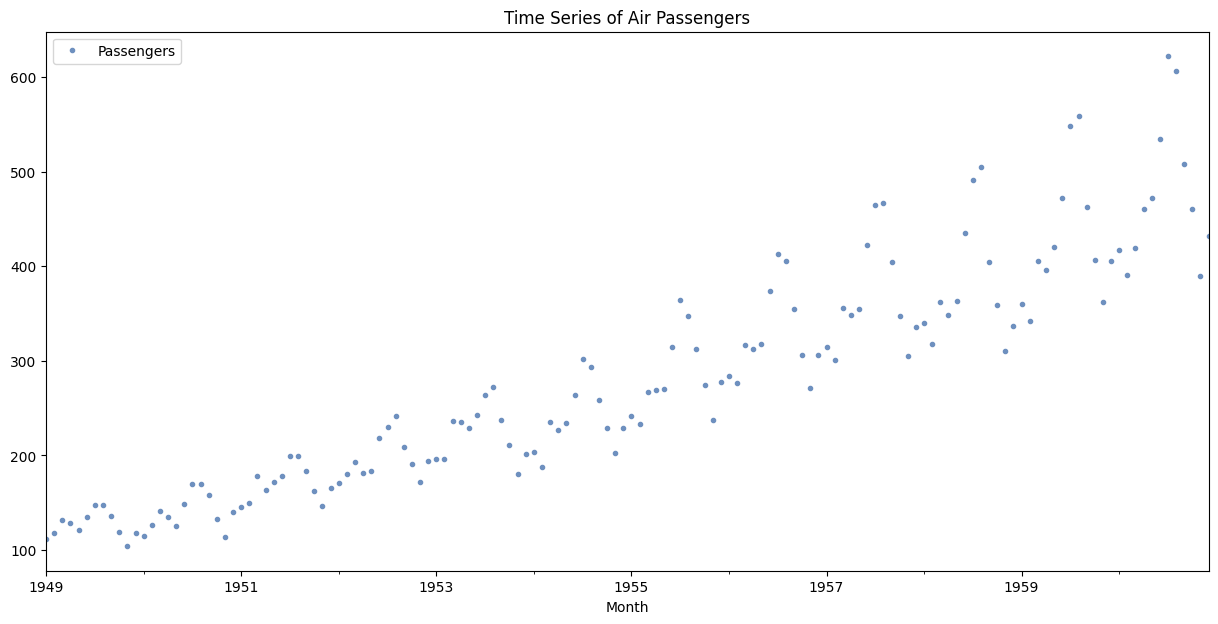

In [58]:
df.plot(
    style='.',
    figsize=(15,7),
    color=col_pal[0],
    title= 'Time Series of Air Passengers'
        )

In [59]:
df.index.max()

Timestamp('1960-12-01 00:00:00')

# Train/ Test Split

In [60]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [61]:
train = df.loc['1949-01-01':'1958-12-01']
test = df.loc['1959-01-01':]

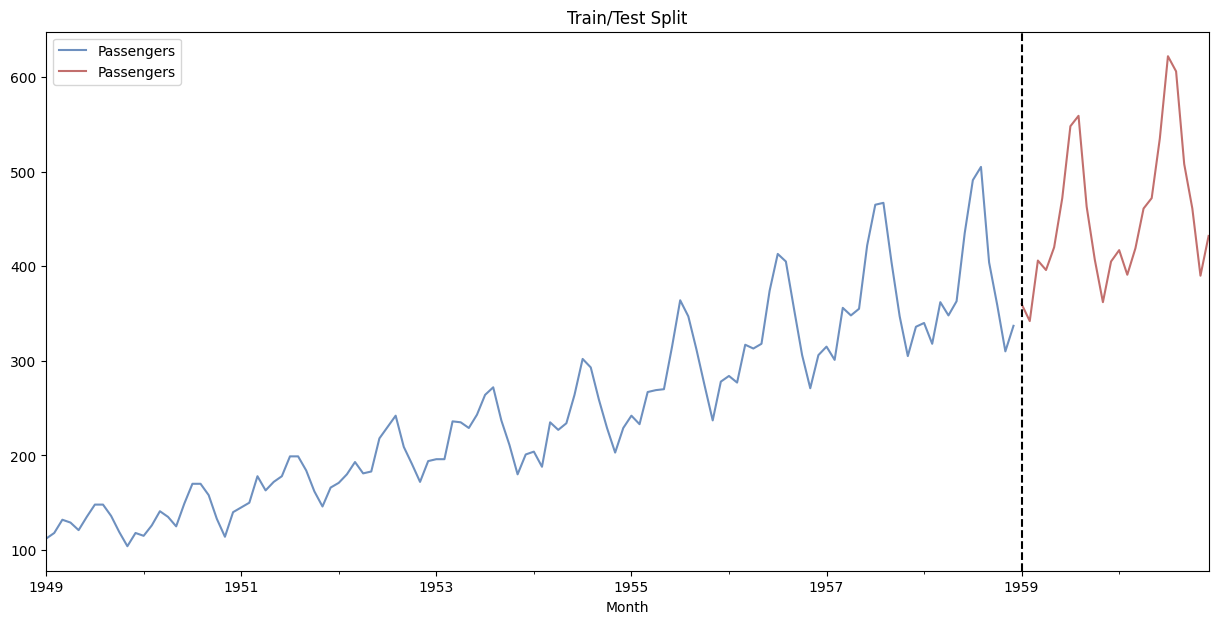

In [62]:
fig, ax = plt.subplots(figsize=(15,7))

train.plot(ax=ax, color= col_pal[0], label='train')
test.plot(ax=ax, color= col_pal[5], label='test')
ax.axvline('1959-01-01', color='black', ls='--')
ax.set_title('Train/Test Split')
plt.legend()

In [63]:
# Plot data in a year
df_1949 = df.loc['1949-01-01':'1949-12-01']
df_1950 = df.loc['1950-01-01':'1950-12-01']
df_1951 = df.loc['1951-01-01':'1951-12-01']
df_1952 = df.loc['1952-01-01':'1952-12-01']

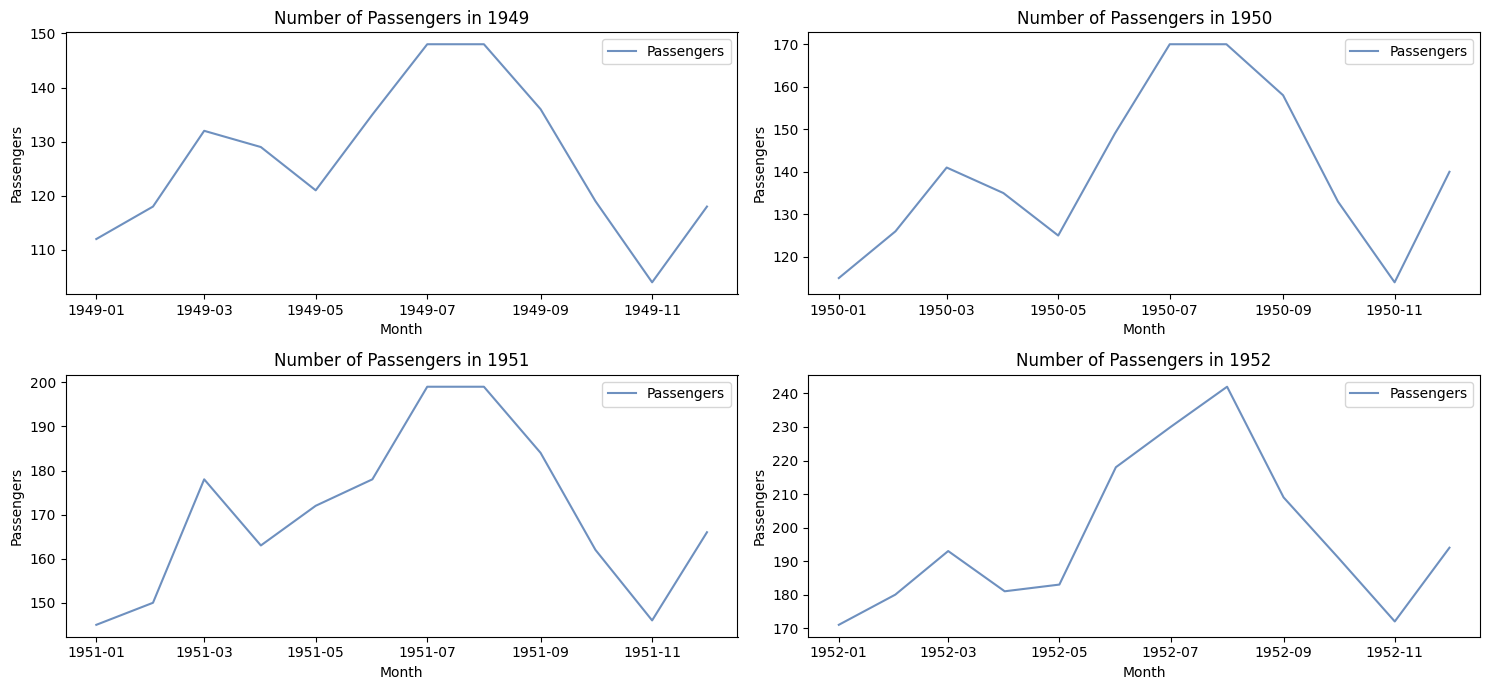

In [64]:
fig, ax = plt.subplots(2,2, figsize=(15,7))

sns.lineplot(x='Month', y='Passengers', data= df_1949, ax=ax[0,0], color= col_pal[0], label='Passengers')
ax[0,0].set_title('Number of Passengers in 1949')

sns.lineplot(x='Month', y='Passengers', data= df_1950, ax=ax[0,1], color= col_pal[0], label='Passengers')
ax[0,1].set_title('Number of Passengers in 1950')

sns.lineplot(x='Month', y='Passengers', data= df_1951, ax=ax[1,0], color= col_pal[0], label='Passengers')
ax[1,0].set_title('Number of Passengers in 1951')

sns.lineplot(x='Month', y='Passengers', data= df_1952, ax=ax[1,1], color= col_pal[0], label='Passengers')
ax[1,1].set_title('Number of Passengers in 1952')

plt.tight_layout()
plt.show()

# Feature Creation

In [65]:
def create_feature(df):
  df = df.copy()
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['quarter'] = df.index.quarter
  return df

In [66]:
df = create_feature(df)

In [67]:
df

,Passengers,month,year,quarter
Month,,,,
1949-01-01,112,1,1949,1
1949-02-01,118,2,1949,1
1949-03-01,132,3,1949,1
1949-04-01,129,4,1949,2
1949-05-01,121,5,1949,2
...,...,...,...,...
1960-08-01,606,8,1960,3
1960-09-01,508,9,1960,3
1960-10-01,461,10,1960,4


# Visualize

<ipython-input-68-708e55ebabf3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='Passengers', data=df, palette='Blues')


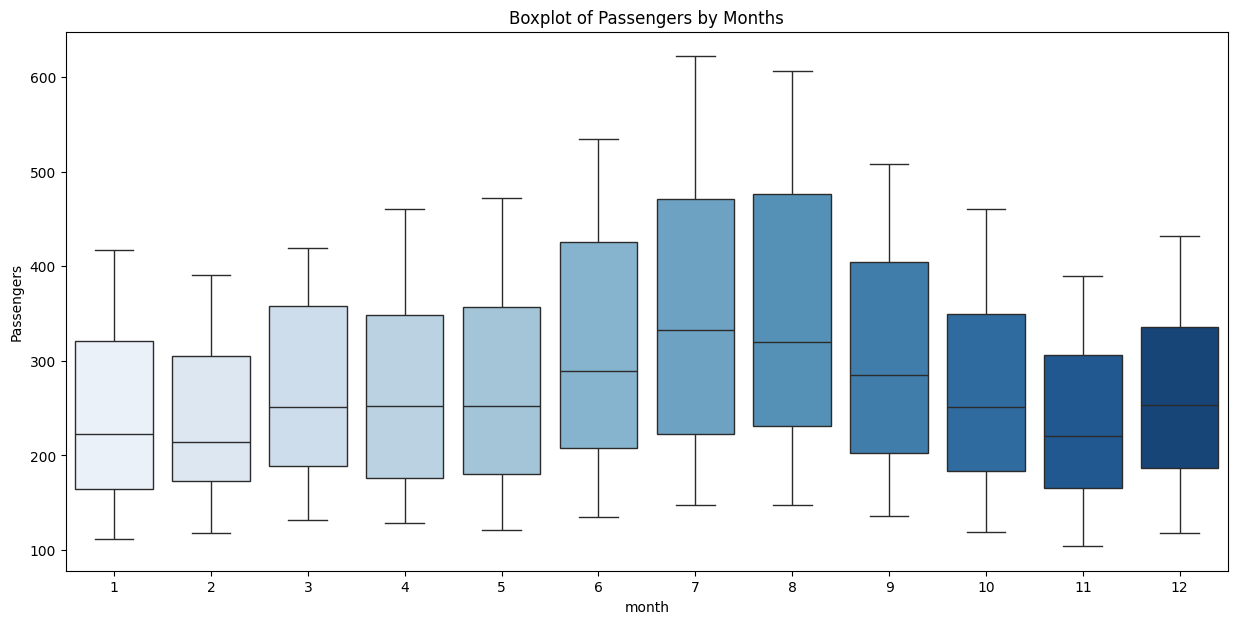

In [68]:
fig, ax = plt.subplots(figsize=(15,7))

sns.boxplot(x='month', y='Passengers', data=df, palette='Blues')
ax.set_title('Boxplot of Passengers by Months')
plt.show()

<ipython-input-69-c1c6a38bf7af>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='year', y='Passengers', data=df, palette='Blues')


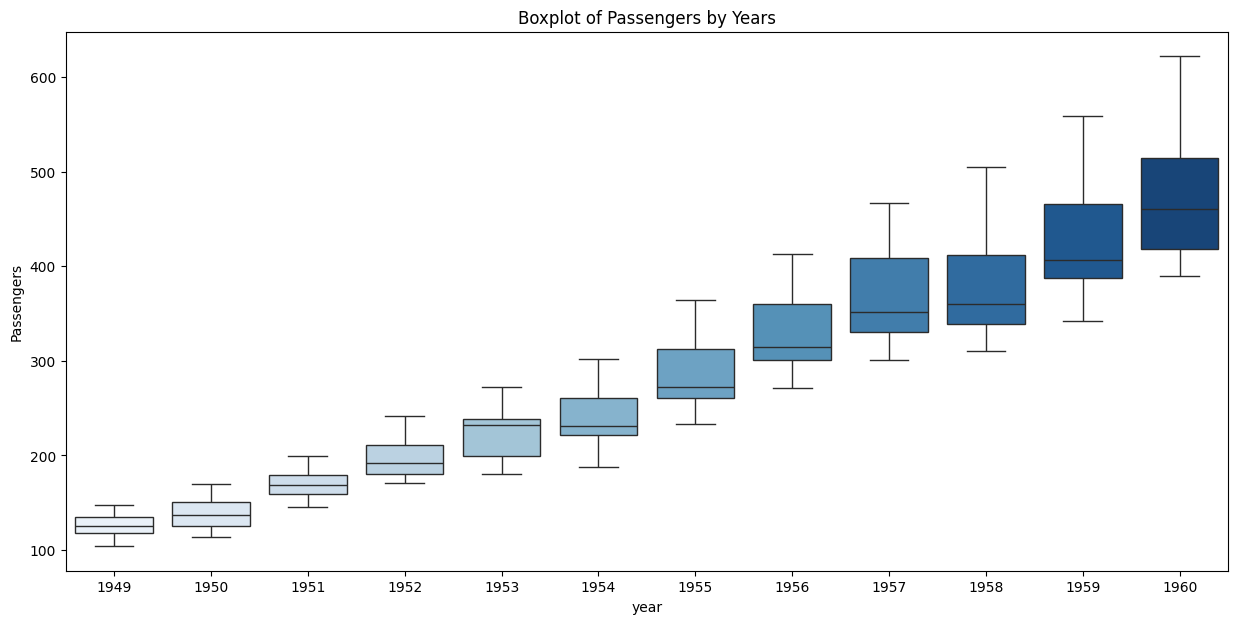

In [69]:
fig, ax = plt.subplots(figsize=(15,7))

sns.boxplot(x='year', y='Passengers', data=df, palette='Blues')
ax.set_title('Boxplot of Passengers by Years')
plt.show()

<ipython-input-70-0c1a545910bd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quarter', y='Passengers', data=df, palette='Blues')


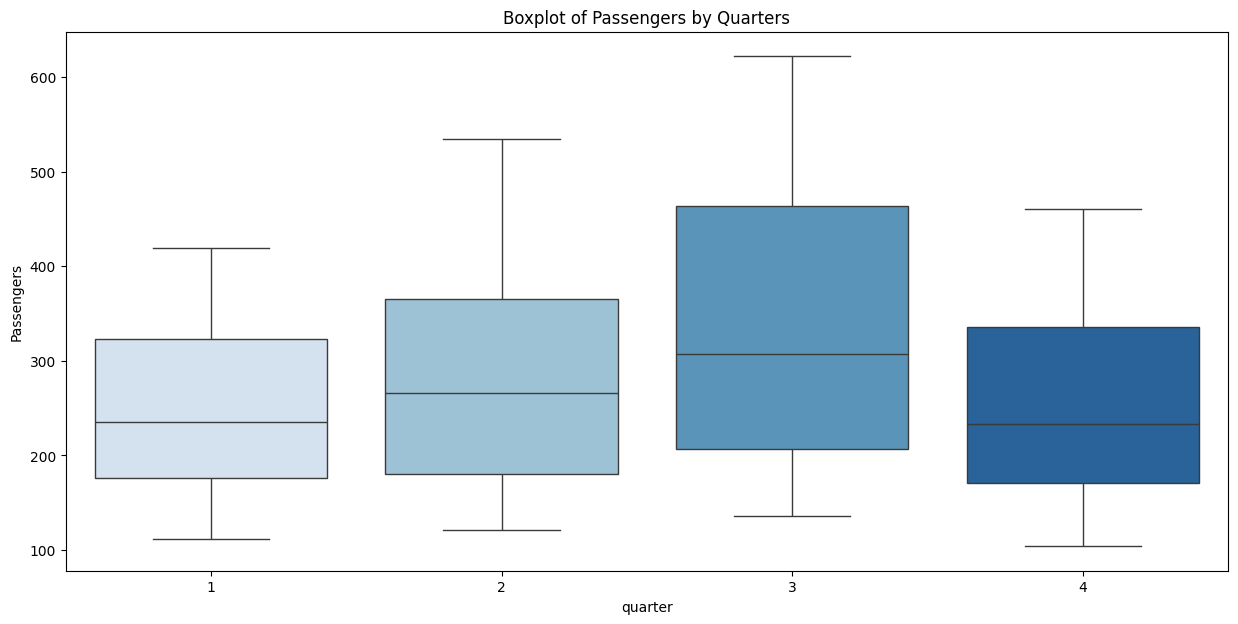

In [70]:
fig, ax = plt.subplots(figsize=(15,7))

sns.boxplot(x='quarter', y='Passengers', data=df, palette='Blues')
ax.set_title('Boxplot of Passengers by Quarters')
plt.show()

# Modelling

In [71]:
train

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1958-08-01,505
1958-09-01,404
1958-10-01,359


In [72]:
train = create_feature(train)
test = create_feature(test)

In [73]:
feature = ['month', 'year', 'quarter']
target = 'Passengers'

In [74]:
X_train = train[feature]
y_train = train[target]
X_test = test[feature]
y_test = test[target]

In [75]:
!pip install scikit-learn==1.0.2

  Using cached scikit-learn-1.0.2.tar.gz (6.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [76]:
model = xgb.XGBRegressor(n_estimators=1000,
                         early_stopping_rounds=50,
                         learning_rate = 0.05)

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)

[0]	validation_0-rmse:90.42966	validation_1-rmse:213.91351
[100]	validation_0-rmse:3.14988	validation_1-rmse:80.49828
[200]	validation_0-rmse:0.99824	validation_1-rmse:77.19846
[300]	validation_0-rmse:0.60886	validation_1-rmse:77.01642
[400]	validation_0-rmse:0.25123	validation_1-rmse:77.00004
[500]	validation_0-rmse:0.12219	validation_1-rmse:76.99495
[516]	validation_0-rmse:0.10823	validation_1-rmse:76.99501


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importance

In [77]:
model.feature_importances_

array([0.06982552, 0.93017447, 0.        ], dtype=float32)

In [78]:
fi = pd.DataFrame(data= model.feature_importances_,
             index= model.feature_names_in_,
             columns=['Importance'])

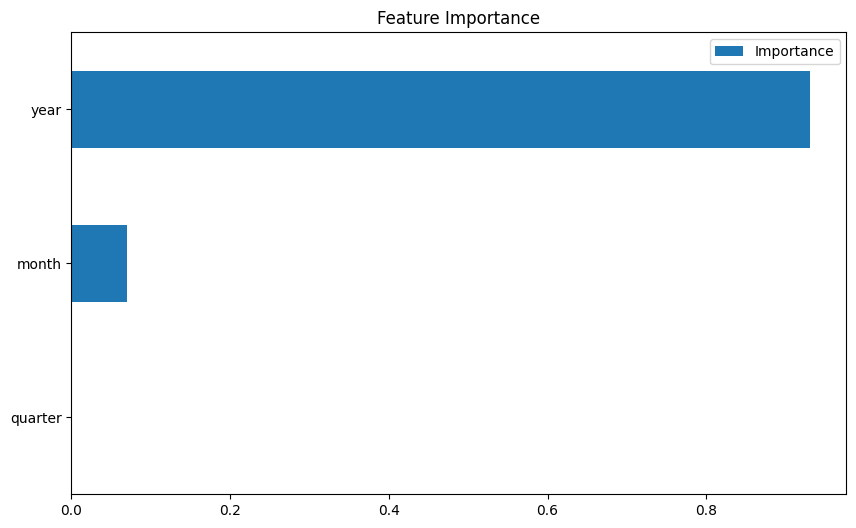

In [79]:
fi.sort_values('Importance').plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()

# Forecast on Test

In [80]:
test['prediction'] = model.predict(X_test)

In [81]:
# df = df.merge(test[['prediction']], how='left', left_index= True, right_index=True)

In [82]:
df = df.join(test[['prediction']], how='left')

In [83]:
df

,Passengers,month,year,quarter,prediction
Month,,,,,
1949-01-01,112,1,1949,1,NaN
1949-02-01,118,2,1949,1,NaN
1949-03-01,132,3,1949,1,NaN
1949-04-01,129,4,1949,2,NaN
1949-05-01,121,5,1949,2,NaN
...,...,...,...,...,...
1960-08-01,606,8,1960,3,504.955750
1960-09-01,508,9,1960,3,404.099030
1960-10-01,461,10,1960,4,358.890442


<Axes: xlabel='Month', ylabel='Passengers'>

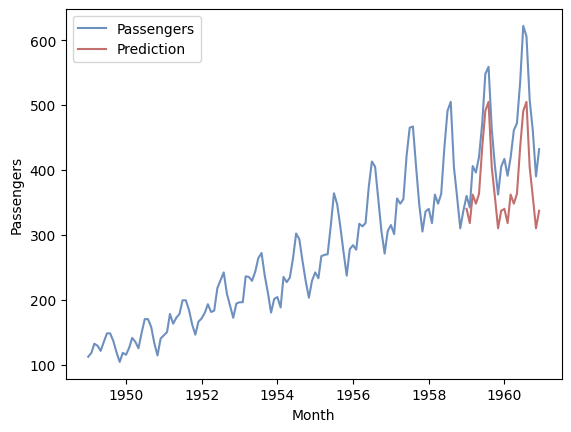

In [84]:
sns.lineplot(data=df, x=df.index, y='Passengers', color=col_pal[0], label='Passengers')
sns.lineplot(data=df, x=df.index, y='prediction', color=col_pal[5], label='Prediction')

Text(0.5, 1.0, 'Number of Passengers in 1959 and 1960')

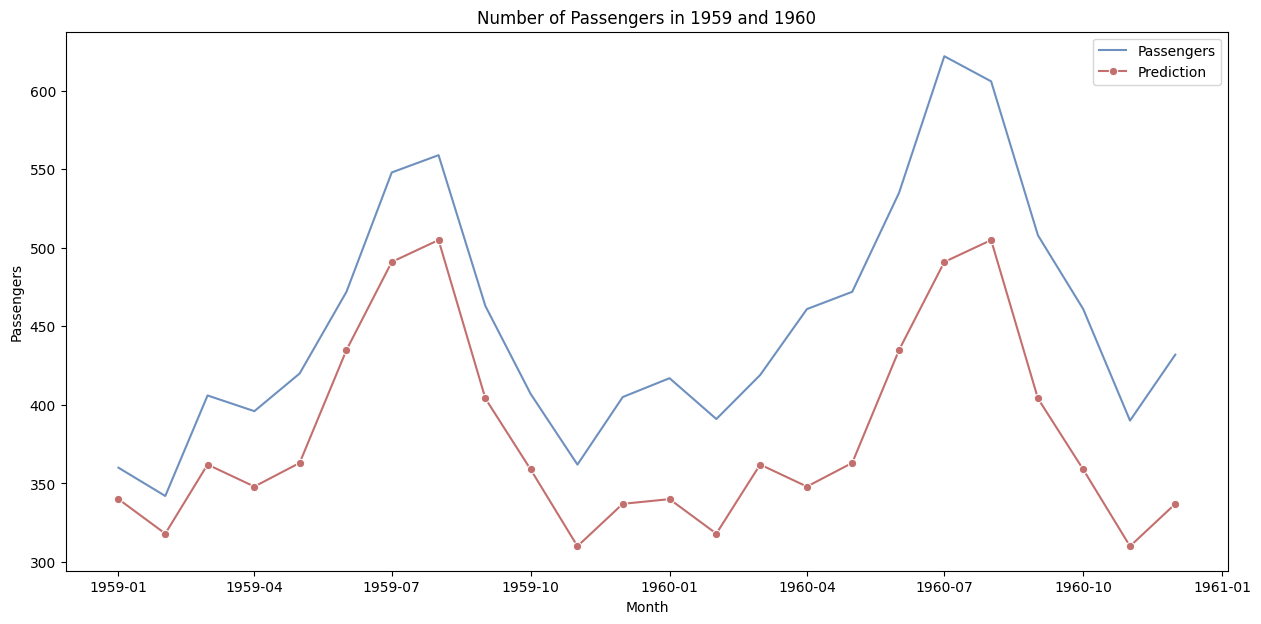

In [85]:
fig, ax = plt.subplots(figsize=(15,7))
pred = df.loc['1959-01-01':]

sns.lineplot(x='Month', y='Passengers', data= pred, color= col_pal[0], label='Passengers')
sns.lineplot(x='Month', y='prediction', data= pred, marker= 'o', color= col_pal[5], label='Prediction')
ax.set_title('Number of Passengers in 1959 and 1960')

In [86]:
score = np.sqrt(mean_squared_error(y_test, test['prediction']))

print(f'RMSE Score on the Test is:{score:0.2f}')

RMSE Score on the Test is:76.99


# Calculate Error by Month

In [87]:
test['error'] = test[target] - test['prediction']

In [88]:
test['month'] = test.index.month

In [89]:
test.groupby('month')['error'].mean().sort_values(ascending= False)

,error
month,
7,93.985565
5,82.929230
12,81.501526
9,81.400970
4,80.509155
8,77.544250
10,75.109558
6,68.563721
11,65.986816
